In [2]:
import numpy as np
import pandas as pd
import heartpy as hp
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

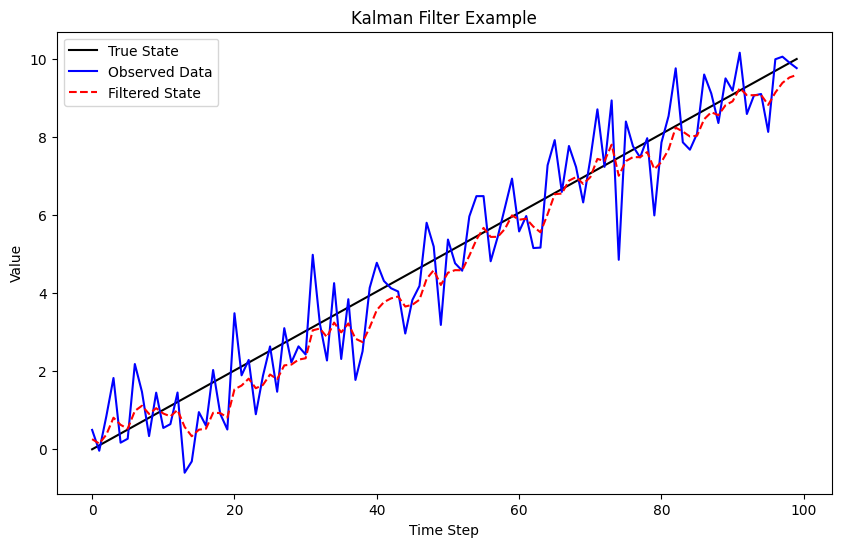

In [3]:

def kalman_filter(observed_data, initial_state, initial_estimate_error, process_variance, measurement_variance):
    """
    Kalman filter implementation.

    Parameters:
    - observed_data: List or array of observed measurements.
    - initial_state: Initial state estimate.
    - initial_estimate_error: Initial error estimate.
    - process_variance: Process noise variance.
    - measurement_variance: Measurement noise variance.

    Returns:
    - filtered_states: List of filtered state estimates.
    """

    # Initialize variables
    num_time_steps = len(observed_data)
    filtered_states = np.zeros(num_time_steps)
    state_estimate = initial_state
    estimate_error = initial_estimate_error

    # Kalman filter loop
    for t in range(num_time_steps):
        # Prediction step
        predicted_state = state_estimate
        predicted_estimate_error = estimate_error + process_variance

        # Update step
        kalman_gain = predicted_estimate_error / (predicted_estimate_error + measurement_variance)
        state_estimate = predicted_state + kalman_gain * (observed_data[t] - predicted_state)
        estimate_error = (1 - kalman_gain) * predicted_estimate_error

        # Save the filtered state estimate
        filtered_states[t] = state_estimate

    return filtered_states

# Generate some example data
np.random.seed(42)
true_state = np.linspace(0, 10, 100)
observed_data = true_state + np.random.normal(0, 1, size=len(true_state))

# Set initial parameters
initial_state_estimate = 0
initial_estimate_error = 1
process_variance = 0.1
measurement_variance = 1

# Run the Kalman filter
filtered_states = kalman_filter(observed_data, initial_state_estimate, initial_estimate_error, process_variance, measurement_variance)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(true_state, label='True State', color='black')
plt.plot(observed_data, label='Observed Data', linestyle='-', color='blue')
plt.plot(filtered_states, label='Filtered State', linestyle='--', color='red')
plt.legend()
plt.title('Kalman Filter Example')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()


Original Signal to Noise Ratio: 3.6120068756125576 dB
Signal after applying Kalman Filter to Noise Ratio: -0.34191815429512773 dB
Original Signal to Signal after applying Kalman Filter Ratio: 3.9539250299076856 dB


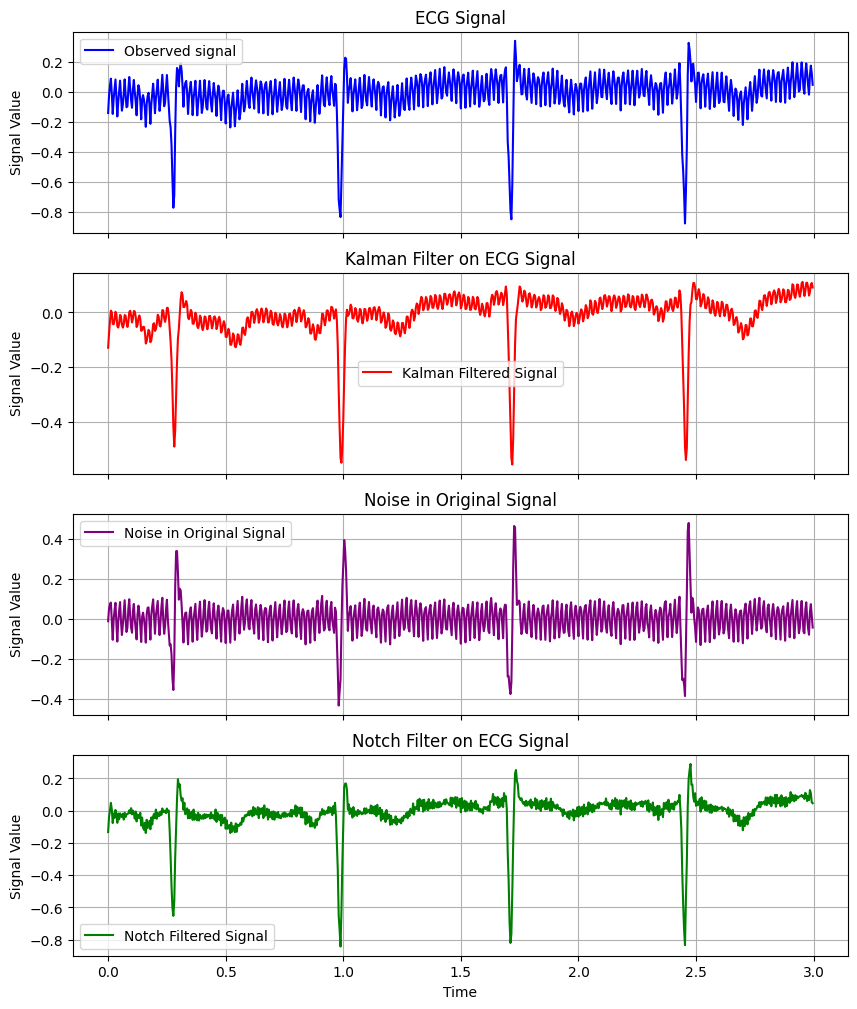

In [6]:
def kalman_filter(observed_data, initial_state, initial_estimate_error, process_variance, measurement_variance):
    num_time_steps = len(observed_data)
    filtered_states = np.zeros(num_time_steps)
    state_estimate = initial_state
    estimate_error = initial_estimate_error

    for t in range(num_time_steps):
        predicted_state = state_estimate
        predicted_estimate_error = estimate_error + process_variance
        kalman_gain = predicted_estimate_error / (predicted_estimate_error + measurement_variance)
        state_estimate = predicted_state + kalman_gain * (observed_data[t] - predicted_state)
        estimate_error = (1 - kalman_gain) * predicted_estimate_error
        filtered_states[t] = state_estimate

    return filtered_states

# Load ECG data from a tab-separated CSV file
file = "E:\\SEM-4\\P1-Export.txt"
time = int(input("Enter the number of seconds to be visualized: "))
df = pd.read_csv(file, sep='\t', header=None,
                 skiprows=3000000, nrows=time*256, usecols=[29], encoding='utf_16_le')
df1 = df[~df.apply(lambda row: row.astype(str).str.contains('AMPSAT|SHORT').any(), axis=1)]
df1 = df.apply(pd.to_numeric, errors='coerce')
df1 = df.dropna()

# Create a time array based on a sampling rate of 256 Hz
sampling_rate = 256
second = np.arange(0, df1.shape[0]) / sampling_rate

# Create subplots for each channel
observed_data = df1.values
second = np.arange(0, df1.shape[0]) / sampling_rate

# Set initial parameters
initial_state_estimate = 0
initial_estimate_error = 1

# Experiment with different values for process_variance and measurement_variance
process_variance = 0.01  # Adjust this value
measurement_variance = 0.1  # Adjust this value

# Run the Kalman filter
filtered_states = kalman_filter(observed_data, initial_state_estimate, initial_estimate_error, process_variance, measurement_variance)

# Using Notch Filter
filtered = hp.filtering.filter_signal(df1.iloc[:, 0], cutoff=50, sample_rate=256.0, filtertype='notch')

# Plot the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plot the observed signal in the first subplot
ax1.plot(second, df1.iloc[:, 0], label='Observed signal', linestyle='-', color='blue')
ax1.legend()
ax1.grid(True)
ax1.set_ylabel('Signal Value')
ax1.set_title('ECG Signal')

# Plot the filtered signal using Kalman filter in the second subplot
ax2.plot(second, filtered_states, label='Kalman Filtered Signal', linestyle='-', color='red')
ax2.legend()
ax2.grid(True)
ax2.set_title('Kalman Filter on ECG Signal')
ax2.set_ylabel('Signal Value')

# Plot the noise in the original signal in the third subplot
ax3.plot(second, df1.iloc[:, 0] - filtered_states, label='Noise in Original Signal', linestyle='-', color='purple')
ax3.legend()
ax3.grid(True)
ax3.set_title('Noise in Original Signal')
ax3.set_ylabel('Signal Value')

# Plot the filtered signal using Notch filter in the fourth subplot
ax4.plot(second, filtered, label='Notch Filtered Signal', linestyle='-', color='green')
ax4.legend()
ax4.grid(True)
ax4.set_title('Notch Filter on ECG Signal')
ax4.set_xlabel('Time')
ax4.set_ylabel('Signal Value')

# Calculate evaluation metrics
original_signal = df1.iloc[:, 0]
noise = original_signal - filtered_states

# Original Signal to Noise Ratio (SNR)
snr_original = 10 * np.log10(np.var(original_signal) / np.var(noise))

# Signal after applying Kalman Filter to Noise Ratio
snr_kalman = 10 * np.log10(np.var(filtered_states) / np.var(noise))

# Original Signal to Signal after applying Kalman Filter Ratio
snr_signal_kalman = 10 * np.log10(np.var(original_signal) / np.var(filtered_states))

# Print evaluation metrics
print(f"Original Signal to Noise Ratio: {snr_original} dB")
print(f"Signal after applying Kalman Filter to Noise Ratio: {snr_kalman} dB")
print(f"Original Signal to Signal after applying Kalman Filter Ratio: {snr_signal_kalman} dB")

plt.show()
